# Clasificación de Hojas de Café

### Cargar las anotaciones del dataset

In [1]:
import json

annotations_file="RoCoLe.json"

with open(annotations_file,'r') as f:
    annotations=json.load(f)

### Dimensión del dataset

In [2]:
len(annotations)

1560

### Esquema de las anotaciones

In [3]:
annotations[1]

{'ID': 'cjvnf878wfzzd0838svwmv6gu',
 'DataRow ID': 'cjvnehagg0jhv0ctne7uze0m7',
 'Labeled Data': 'https://storage.googleapis.com/labelbox-193903.appspot.com/cjs5g735orqbe0b29ip8a1k1s%2F24a51d91-3220-414f-479b-4182739c011c-C1P2E2.jpg',
 'Label': {'Leaf': [{'state': 'unhealthy',
    'geometry': [{'x': 105, 'y': 526},
     {'x': 213, 'y': 547},
     {'x': 357, 'y': 496},
     {'x': 518, 'y': 446},
     {'x': 718, 'y': 416},
     {'x': 911, 'y': 420},
     {'x': 1088, 'y': 420},
     {'x': 1185, 'y': 446},
     {'x': 1323, 'y': 471},
     {'x': 1396, 'y': 531},
     {'x': 1468, 'y': 586},
     {'x': 1539, 'y': 618},
     {'x': 1523, 'y': 632},
     {'x': 1488, 'y': 632},
     {'x': 1442, 'y': 643},
     {'x': 1415, 'y': 680},
     {'x': 1383, 'y': 719},
     {'x': 1341, 'y': 767},
     {'x': 1277, 'y': 804},
     {'x': 1180, 'y': 822},
     {'x': 1125, 'y': 864},
     {'x': 1026, 'y': 875},
     {'x': 895, 'y': 859},
     {'x': 794, 'y': 845},
     {'x': 672, 'y': 815},
     {'x': 610, 'y'

### Crear una clase que contenga la información de las hojas

In [4]:
import cv2

class CoffeeLeaf:    
    def __init__(self, leaf_id, image_bgr, state, classification, geometry):
        self.id = leaf_id
        self.image_bgr = image_bgr
        self.image_gray = None
        self.image_hsv = None
        self.image_rgb = None
        self.state_manual = state
        self.state_computed = None
        self.classification_manual = classification
        self.classification_computed = None
        self.geometry = geometry
        self._process_colors()
    
    def _process_colors(self):
        self.image_gray = cv2.cvtColor(self.image_bgr, cv2.COLOR_BGR2GRAY)
        self.image_hsv = cv2.cvtColor(self.image_bgr, cv2.COLOR_BGR2HSV)
        self.image_rgb = cv2.cvtColor(self.image_bgr, cv2.COLOR_BGR2RGB)
        

### Cargar las imágenes del dataset en objetos CoffeeLeaf

In [5]:
# REMOVER una vez que el proceso esté listo para aplicarse de manera general, es decir,
# trabajar temporalmente con una sola hoja, para reducir el tiempo de procesamiento
annotations = [annotations[1]]

In [6]:
IMAGES_PATH = "../rocole_photos/"

coffee_leaves = []

for annotation in annotations:
    leaf_id = annotation["ID"]
    state = annotation["Label"]["Leaf"][0]["state"]
    geometry = annotation["Label"]["Leaf"][0]["geometry"]
    classification = annotation["Label"]["classification"]
    leaf_image = f"{IMAGES_PATH}/{leaf_id}.jpeg"
    image_bgr = cv2.imread(leaf_image)
    coffee_leaf = CoffeeLeaf(leaf_id, image_bgr, state, classification, geometry)
    coffee_leaves.append(coffee_leaf)

### Crear una funcion para mostrar imagenes

In [7]:
import matplotlib.pyplot as plt

def show_image(image_data):
    plt.imshow(image_data)
    plt.axis("off")

Estado: unhealthy
Clasificación: rust_level_2


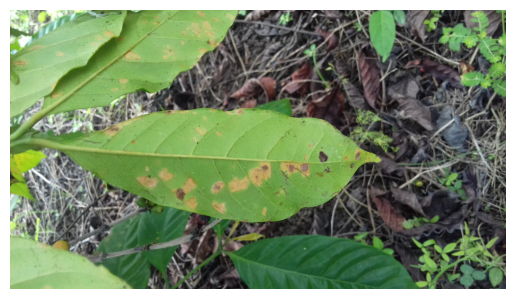

In [8]:
coffee_leaf = coffee_leaves[0]
print(f"Estado: {coffee_leaf.state_manual}")
print(f"Clasificación: {coffee_leaf.classification_manual}")
show_image(coffee_leaf.image_rgb)

### Crear la máscara para la hoja

In [9]:
import numpy as np

polygon_points = [list(point.values()) for point in coffee_leaf.geometry]
polygon = np.array(polygon_points)

In [10]:
x,y,w,h = cv2.boundingRect(polygon)

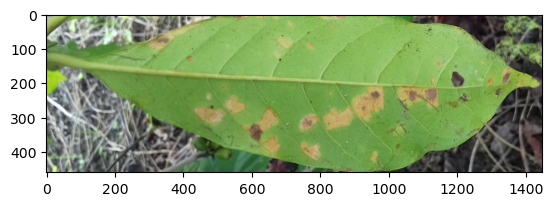

In [11]:
cropped_image = coffee_leaf.image_rgb[y:y+h, x:x+w].copy()
#show_image(cropped_image)
plt.imshow(cropped_image, cmap='gray')
plt.show()

In [12]:
cropped_image.shape

(460, 1449, 3)

In [13]:
# Selecciona los minimos por columnas (axis=0)
start = polygon.min(axis=0)

In [14]:
polygon = polygon-start

In [15]:
mask = np.zeros(cropped_image.shape, np.uint8)

In [16]:
mask.shape

(460, 1449, 3)

In [17]:
image_contours = cropped_image.copy()
CONTOURS = -1 # All contours
COLOR = (255, 255, 255) # White
THICKNESS = 5
ret = cv2.drawContours(image_contours, [polygon], CONTOURS, COLOR, THICKNESS)

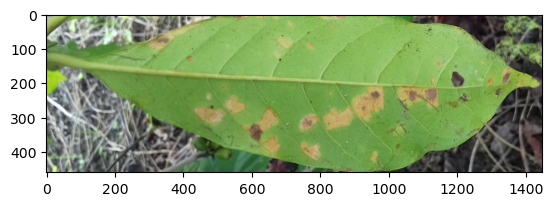

In [18]:
plt.imshow(cropped_image)
plt.show()

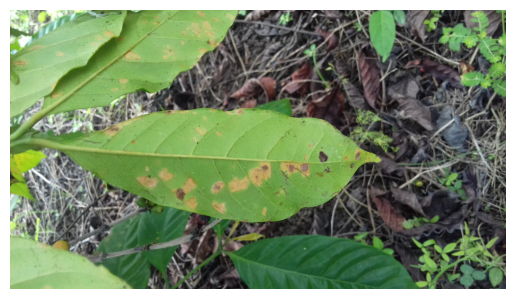

In [19]:
show_image(coffee_leaf.image_rgb)

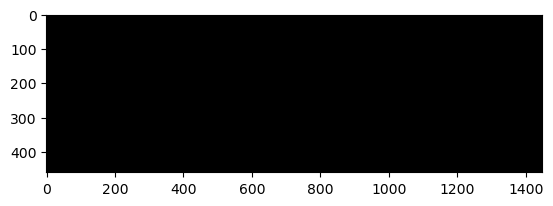

In [20]:
plt.imshow(mask, cmap='gray')
plt.show()

In [21]:
CONTOURS = -1 # All contours
COLOR = (255, 255, 255) # White
THICKNESS = -1 # Fill
image_contour = cv2.drawContours(mask, [polygon], CONTOURS, COLOR, THICKNESS)

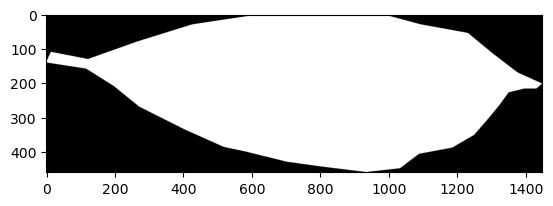

In [22]:
plt.imshow(mask, cmap='gray')
plt.show()

In [35]:
roi = cv2.bitwise_and(cropped_image, mask)

In [36]:
roi.shape

(460, 1449, 3)

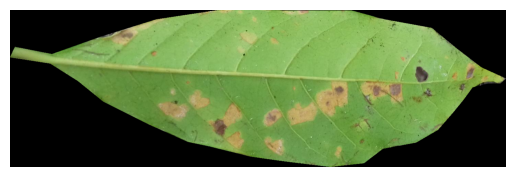

In [37]:
show_image(roi)